# MovieLens-1M数据处理
在这个notebook中，我们会演示使用如何在AlphaIDE中使用MetaSpore，进行数据准备、Spark环境初始化、数据读取、数据分析等基础的操作。

### 1. 数据准备
从MovieLens网站上下载数据，并上传到S3存储。

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip

--2022-05-23 20:13:08--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.12MB/s    in 1.8s    

2022-05-23 20:13:13 (3.12 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [2]:
!unzip ml-1m.zip

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
!aws s3 cp --recursive ml-1m  s3://alphaide-demo/movielens/ml-1m/

upload: ml-1m/README to s3://alphaide-demo/movielens/ml-1m/README
upload: ml-1m/users.dat to s3://alphaide-demo/movielens/ml-1m/users.dat
upload: ml-1m/movies.dat to s3://alphaide-demo/movielens/ml-1m/movies.dat
upload: ml-1m/ratings.dat to s3://alphaide-demo/movielens/ml-1m/ratings.dat


In [4]:
!aws s3 ls s3://alphaide-demo/movielens/ml-1m/

                           PRE rank/
                           PRE schema/
2022-05-23 20:13:14       5577 README
2022-05-23 20:13:14     171308 movies.dat
2022-05-23 20:13:14   24594131 ratings.dat
2022-05-23 20:13:14     134368 users.dat


### 2. Spark环境初始化与数据读取
初始化Spark环境，并读取Movies、Users、Ratings等数据表，测试我们读取过程是否可以顺利完成

In [5]:
import metaspore as ms
import yaml
import argparse
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, LongType, StringType
from functools import reduce

def load_config(path):
    params = dict()
    with open(path, 'r') as stream:
        params = yaml.load(stream, Loader=yaml.FullLoader)
        print('Debug -- load config: ', params)
    return params

def init_spark():
    
    spark_confs={
        "spark.network.timeout":"500",
        "spark.ui.showConsoleProgress": "true",
        "spark.kubernetes.executor.deleteOnTermination":"true",
    }
    spark_session = ms.spark.get_session(local=local,
                                         app_name=app_name,
                                         batch_size=batch_size,
                                         worker_count=worker_count,
                                         server_count=server_count,
                                         worker_memory=worker_memory,
                                         server_memory=server_memory,
                                         coordinator_memory=coordinator_memory,
                                         spark_confs=spark_confs)
    sc = spark_session.sparkContext
    print('Debug -- spark init')
    print('Debug -- version:', sc.version)   
    print('Debug -- applicaitonId:', sc.applicationId)
    print('Debug -- uiWebUrl:', sc.uiWebUrl)
    return spark_session

def stop_spark(spark):
    print('Debug -- spark stop')
    spark.sparkContext.stop()

def read_dataset(**kwargs):
    ### read movies
    movies_schema = StructType([
            StructField("movie_id", LongType(), True),
            StructField("title", StringType(), True),
            StructField("genre", StringType(), True)
    ])

    movies = spark.read.csv(movies_path, sep='::',inferSchema=False, header=False, schema=movies_schema)
    print('Debug -- movies sample:')
    movies.show(10)

    ### read ratings
    ratings_schema = StructType([
            StructField("user_id", LongType(), True),
            StructField("movie_id", LongType(), True),
            StructField("rating", FloatType(), True),
            StructField("timestamp", LongType(), True)
    ])

    ratings = spark.read.csv(ratings_path, sep='::', inferSchema=False, header=False, schema=ratings_schema)
    print('Debug -- ratings sample:')
    ratings.show(10)

    ### read users
    users_schema = StructType([
            StructField("user_id", LongType(), True),
            StructField("gender", StringType(), True),
            StructField("age", IntegerType(), True),
            StructField("occupation", StringType(), True),
            StructField("zip", StringType(), True)
    ])

    users = spark.read.csv(users_path, sep='::', inferSchema=False, header=False, schema=users_schema)
    print('Debug -- users sample:')
    users.show(10)

    return users, movies, ratings

def merge_dataset(users, movies, ratings):
    # merge movies, users, ratings
    dataset = ratings.join(users, on=ratings.user_id==users.user_id, how='leftouter').drop(users.user_id)
    dataset = dataset.join(movies, on=dataset.movie_id==movies.movie_id,how='leftouter').drop(movies.movie_id)
    dataset = dataset.select('user_id', \
                            'gender', \
                            'age', \
                            'occupation', \
                            'zip', \
                            'movie_id', \
                            'title', \
                            'genre', \
                            'rating', \
                            'timestamp'
                            )
    print('Debug -- dataset sample:')
    dataset.show(10)
    return dataset

In [6]:
print('Debug -- Movielens Feature Generation Demo')
params = load_config('./1-data_exploration.yaml')
locals().update(params)
spark = init_spark()

Debug -- Movielens Feature Generation Demo
Debug -- load config:  {'app_name': 'MovieLens-1M Data', 'local': True, 'worker_count': 2, 'server_count': 2, 'batch_size': 1024, 'worker_memory': '7G', 'server_memory': '7G', 'coordinator_memory': '7G', 'movies_path': 's3://alphaide-demo/movielens/ml-1m/movies.dat', 'ratings_path': 's3://alphaide-demo/movielens/ml-1m/ratings.dat', 'users_path': 's3://alphaide-demo/movielens/ml-1m/users.dat'}


22/05/23 20:13:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Debug -- spark init
Debug -- version: 3.1.2
Debug -- applicaitonId: local-1653307998805
Debug -- uiWebUrl: http://movielens-102-0:4040


In [7]:
users, movies, ratings = read_dataset(**params)
merged_dataset = merge_dataset(users, movies, ratings)

Debug -- movies sample:
+--------+--------------------+--------------------+
|movie_id|               title|               genre|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Animation|Childre...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|        Comedy|Drama|
|       5|Father of the Bri...|              Comedy|
|       6|         Heat (1995)|Action|Crime|Thri...|
|       7|      Sabrina (1995)|      Comedy|Romance|
|       8| Tom and Huck (1995)|Adventure|Children's|
|       9| Sudden Death (1995)|              Action|
|      10|    GoldenEye (1995)|Action|Adventure|...|
+--------+--------------------+--------------------+
only showing top 10 rows

Debug -- ratings sample:
+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|    1193|   5.0|978300760|
|      1|     661|   3.0|978302109|
|  

### 3.数据分析
针对MovieLens 1M的数据，这个数据集中一共包含了6040个用户对3883部电影进行评价。我们在这里简要的做下数据分析：
* 首先，使用饼图分析一下电影的评分的分布情况，即从1～5评分的百分比；
* 其次，使用增强箱图分析一下不同类型电影的流行度分布，横轴是电影的类型，纵轴是评价电影的用户数量；
* 最后，使用柱状图分析一下用户观看电影的数量分布。

#### 3.1 电影评分分布饼图绘制

In [8]:
# 统计每个打分的人数
star = ratings.groupby('rating').count().sort(F.desc("rating"))
star.show(20,True)

+------+------+
|rating| count|
+------+------+
|   5.0|226310|
|   4.0|348971|
|   3.0|261197|
|   2.0|107557|
|   1.0| 56174|
+------+------+



In [9]:
# 转换成Pandas格式
star_pd = star.toPandas()
print(star_pd)

   rating   count
0     5.0  226310
1     4.0  348971
2     3.0  261197
3     2.0  107557
4     1.0   56174


['5.0 star(s)', '4.0 star(s)', '3.0 star(s)', '2.0 star(s)', '1.0 star(s)']
[226310.0, 348971.0, 261197.0, 107557.0, 56174.0]


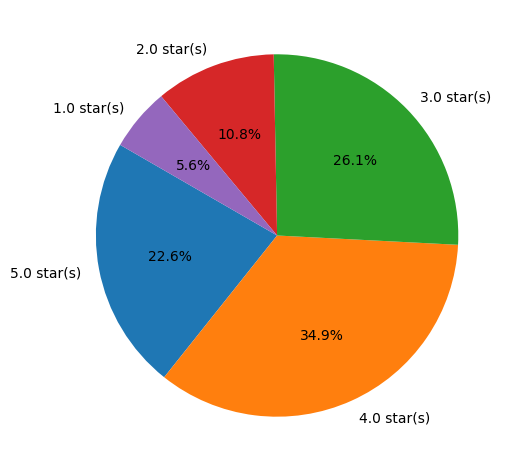

In [10]:
# 将每个评分人数画成饼图
star_score = []
star_count = []
def count_star(row):
    star_score.append(str(row['rating'])+ " star(s)")
    star_count.append(row['count'])
star_pd.apply(count_star, axis=1)
print(star_score)
print(star_count)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6), dpi=100)
plt.pie(star_count,labels=star_score,autopct='%1.1f%%', shadow=False,startangle=150)
plt.savefig('user_rating_pie.png', dpi=100)

#### 3.2 电影流行度增强箱图绘制

In [11]:
# 统计不同类型电影惯看的用户数量
merged_dataset.registerTempTable("merged_dataset")
query="""
select 
    movie_id, 
    single_genre, 
    count(distinct user_id) as rating_users
from 
(
    select 
        user_id,
        movie_id, 
        single_genre
    from 
        merged_dataset
    lateral view explode(split(genre,'\\\\|')) genres AS single_genre 
)
group by 
    movie_id, single_genre
"""
genre_stat = spark.sql(query)
genre_stat.show(20, True)

+--------+------------+------------+
|movie_id|single_genre|rating_users|
+--------+------------+------------+
|    1035|     Musical|         882|
|    2144|      Comedy|         719|
|    2005|   Adventure|         716|
|    3554|     Romance|         119|
|    3702|      Action|        1066|
|     562|       Drama|         478|
|    1025|   Animation|         293|
|    3364|   Film-Noir|         151|
|    1222|         War|        1254|
|    1135|      Comedy|         407|
|    3326|      Comedy|         180|
|     748|      Sci-Fi|         417|
|    3741|       Drama|         241|
|     471|      Comedy|         599|
|    3784|      Comedy|         165|
|    1649| Documentary|         189|
|    2970|   Adventure|          98|
|    1468|      Comedy|         144|
|    1050| Documentary|         146|
|    2377|      Horror|         183|
+--------+------------+------------+
only showing top 20 rows



In [12]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 KB 8.0 MB/s eta 0:00:0000:01


Text(0, 0.5, 'Users')

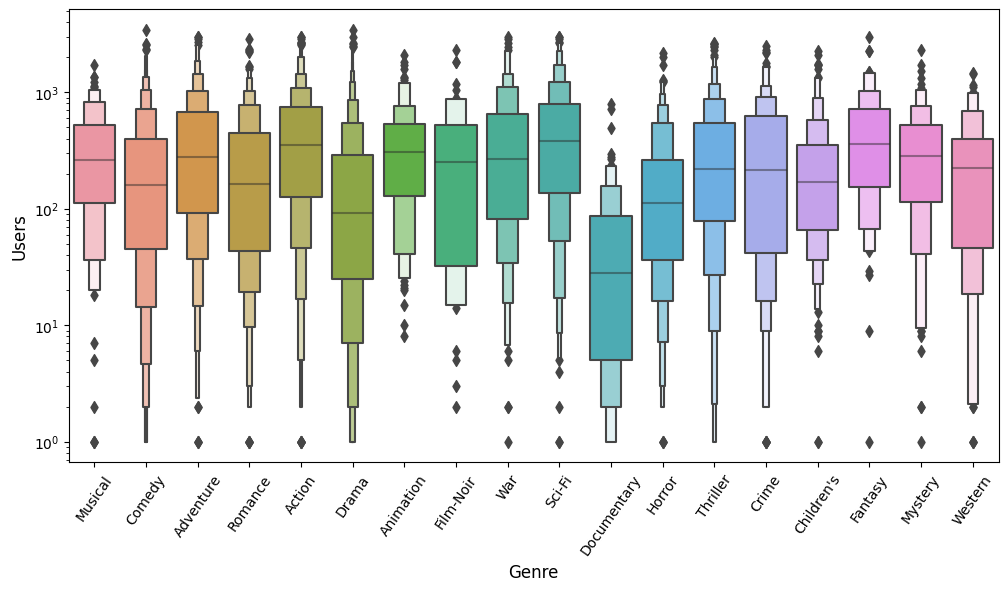

In [13]:
# 将流行度分布使用增强箱图进行表示，横轴是电影的类型，纵轴是评价电影的用户数量
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

genre_stat_pandas = genre_stat.toPandas()
plt.figure(figsize=(12, 6), dpi=100)
sns.boxenplot(x='single_genre', y='rating_users', data =genre_stat_pandas)
plt.yscale('log')
plt.yticks(fontsize=10)
plt.xticks(rotation=55, fontsize=10)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Users',fontsize=12)

#### 3.3 用户观看电影的数量柱状图绘制

In [14]:
# 统计每位用户给多少电影打分
watch = ratings.groupby('user_id').agg(F.countDistinct('movie_id').alias('movie_count'))
watch.show(20,True)

+-------+-----------+
|user_id|movie_count|
+-------+-----------+
|    474|        318|
|    964|         78|
|   1697|        354|
|   1950|        137|
|   2214|         81|
|   2250|         67|
|   2453|        629|
|   2529|        812|
|   3091|         64|
|   5556|        278|
|     26|        400|
|     29|        108|
|   1677|         43|
|   5385|         46|
|   1806|        214|
|   2927|         62|
|   4823|        470|
|   4590|         50|
|   3506|         68|
|   2040|         46|
+-------+-----------+
only showing top 20 rows



In [15]:
# 新加的count_bin是观看电影数量所在的区间
watch = watch.withColumn("count_bin",(watch['movie_count']/100).cast('int'))
watch.show(20,True)

+-------+-----------+---------+
|user_id|movie_count|count_bin|
+-------+-----------+---------+
|    474|        318|        3|
|    964|         78|        0|
|   1697|        354|        3|
|   1950|        137|        1|
|   2214|         81|        0|
|   2250|         67|        0|
|   2453|        629|        6|
|   2529|        812|        8|
|   3091|         64|        0|
|   5556|        278|        2|
|     26|        400|        4|
|     29|        108|        1|
|   1677|         43|        0|
|   5385|         46|        0|
|   1806|        214|        2|
|   2927|         62|        0|
|   4823|        470|        4|
|   4590|         50|        0|
|   3506|         68|        0|
|   2040|         46|        0|
+-------+-----------+---------+
only showing top 20 rows



In [16]:
# 观看电影数量区间对应的人数
watch_count = watch.groupby('count_bin').agg(F.countDistinct('user_id')\
                                        .alias('user_count'))\
                                        .sort(F.asc("count_bin"))
watch_count.show(20,True)

+---------+----------+
|count_bin|user_count|
+---------+----------+
|        0|      3095|
|        1|      1356|
|        2|       624|
|        3|       360|
|        4|       206|
|        5|       140|
|        6|        82|
|        7|        65|
|        8|        49|
|        9|        22|
|       10|        13|
|       11|         6|
|       12|        13|
|       13|         3|
|       15|         3|
|       17|         1|
|       18|         1|
|       23|         1|
+---------+----------+



In [17]:
# 观影数量区间
count_bin = [x['count_bin'] for x in watch_count.select('count_bin').collect()]
print(count_bin)
# 区间对应人数
count_bin_user_num=[x['user_count'] for x in watch_count.select('user_count').collect()]
print(count_bin_user_num)
# 区间对应的label
x_label = ["%s-%s"%(100*x, 100*x + 100)for x in count_bin]
print(x_label)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 23]


[3095, 1356, 624, 360, 206, 140, 82, 65, 49, 22, 13, 6, 13, 3, 3, 1, 1, 1]
['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800', '800-900', '900-1000', '1000-1100', '1100-1200', '1200-1300', '1300-1400', '1500-1600', '1700-1800', '1800-1900', '2300-2400']


/home/jovyan/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


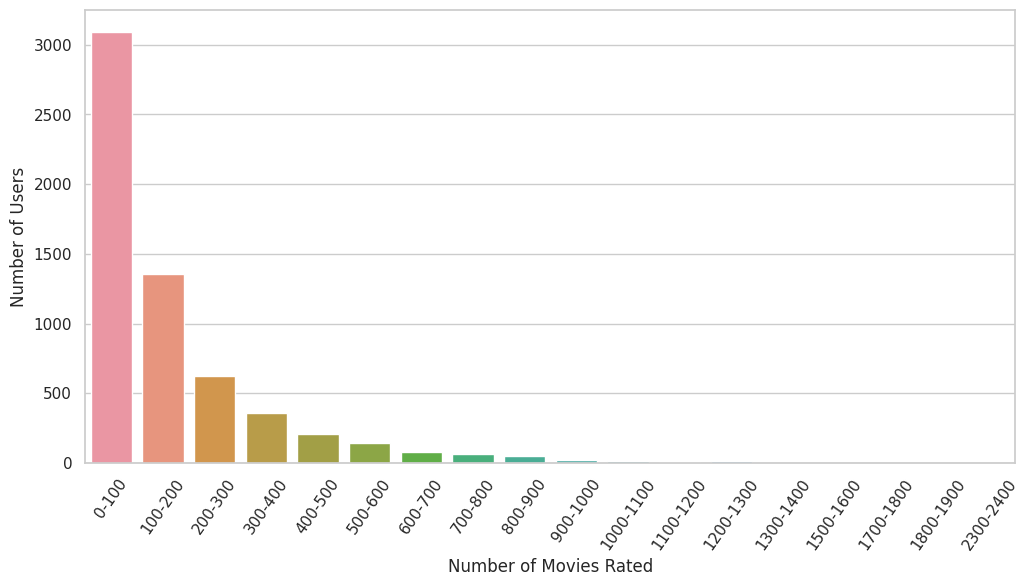

<Figure size 432x288 with 0 Axes>

In [18]:
# 柱状图
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=100)
ax = sns.barplot(count_bin, count_bin_user_num)
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
ax.set_xticklabels(x_label, rotation=55)
plt.show()
plt.savefig('user_watch_count_bin.png', dpi=100)

In [19]:
spark.stop()